pandas 版本较新，使用了 Nullable Strings（可为空字符串类型），而你当前的 anndata 版本（可能是 0.10.x）出于兼容性考虑，默认禁止写入这种格式，以防旧版软件打不开你的 .h5ad 文件。
你可以按照报错提示，在代码开头开启这个开关来解决。

In [25]:
import anndata
# 允许写入 Pandas 的新式字符串格式
anndata.settings.allow_write_nullable_strings = True

1. 导入库与配置

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

# 设置 Scanpy 的绘图参数
sc.settings.verbosity = 3             # 显示日志
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

results_file = 'pbmc3k_results.h5ad'  # 结果保存路径

/tmp/ipykernel_10204/3682314905.py:8: FutureWarning: Use `scanpy.set_figure_params` instead
  sc.settings.set_figure_params(dpi=80, facecolor='white')


2. 下载并读取数据
Scanpy 内置了下载函数，非常方便：

In [12]:
# 下载 3k PBMC 数据（来自 10x Genomics）
# 修改为官方标准函数
adata = sc.datasets.pbmc3k() 
adata.var_names_make_unique()

In [16]:
adata.obs.head() # 查看结果

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes
index,,,,,
AAACATACAACCAC-1,781,2421.0,73.0,3.015283,781
AAACATTGAGCTAC-1,1352,4903.0,186.0,3.793596,1352
AAACATTGATCAGC-1,1131,3149.0,28.0,0.889171,1131
AAACCGTGCTTCCG-1,960,2639.0,46.0,1.743085,960
AAACCGTGTATGCG-1,522,981.0,12.0,1.223242,522


3. 预处理与质控 (QC)

In [17]:
# 计算线粒体基因比例， pp 是 Pre-Processing（预处理）的缩写
# sc.pp (Pre-processing)：数据清洗、标准化、质控、去噪。
# sc.tl (Tools)：更高级的分析，如聚类、降维（UMAP）、轨迹追踪。
# sc.pl (Plotting)：绘图和可视化。
# percent_top=None含义：是否计算前 N 个高表达基因所占的比例。作用：通常设为 None 或 [50, 100, 200, 500]。
# 在单细胞中，如果前 50 个基因就占了总表达量的 80%，说明这个细胞的多样性极低，可能是文库质量问题。
# log1p=False含义：是否对计算出的指标进行 $log(x+1)$ 处理。作用：这里设为 False，我们通常直接看原始比例和计数。
# inplace=True含义：是否直接修改原对象。作用：设为 True，意味着该函数没有返回值，而是直接更新你的 adata 变量。
# 这能节省内存（这对你保持 C 盘空间也有好处）。

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs.head() # 查看结果，你会发现多了几列：
# n_genes_by_counts：每个细胞检测到了多少个基因（基因丰度）。
# total_counts：每个细胞的总 UMI 计数（测序深度）。
# pct_counts_mt：最重要的指标——线粒体基因占比。


/tmp/ipykernel_10204/2406383915.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')


,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes
index,,,,,
AAACATACAACCAC-1,779,2419.0,73.0,3.017776,781
AAACATTGAGCTAC-1,1352,4903.0,186.0,3.793596,1352
AAACATTGATCAGC-1,1129,3147.0,28.0,0.889736,1131
AAACCGTGCTTCCG-1,960,2639.0,46.0,1.743085,960
AAACCGTGTATGCG-1,521,980.0,12.0,1.224490,522


In [ ]:
# 过滤细胞
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.pct_counts_mt < 5, :] # 过滤线粒体占比高的细胞
adata.obs.head(50)


/home/zhen/miniforge3/envs/scanpy_env/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:161: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes
index,,,,,
AAACATACAACCAC-1,779,2419.0,73.0,3.017776,779
AAACATTGAGCTAC-1,1352,4903.0,186.0,3.793596,1352
AAACATTGATCAGC-1,1129,3147.0,28.0,0.889736,1129
AAACCGTGCTTCCG-1,960,2639.0,46.0,1.743085,960
AAACCGTGTATGCG-1,521,980.0,12.0,1.224490,521
AAACGCACTGGTAC-1,781,2163.0,36.0,1.664355,781
AAACGCTGACCAGT-1,782,2175.0,83.0,3.816092,782
AAACGCTGGTTCTT-1,790,2260.0,70.0,3.097345,790
AAACGCTGTAGCCA-1,532,1275.0,15.0,1.176471,532


这行代码是单细胞分析中承上启下的关键步骤。它的目的是：从 2 万多个基因中，剔除掉那些在所有细胞里表达都差不多的“背景噪音”，只保留那些在不同细胞群之间表现迥异的“特征基因”。
简单来说，这就是生信里的“划重点”。
🔍 参数深度拆解
这个函数通过计算每个基因的 平均表达量 (Mean) 和 离散度 (Dispersion，通常指方差归一化后的值) 来筛选基因。
1. min_mean=0.0125 和 max_mean=3 含义：基因平均表达量的阈值。
为什么要设上限？：在单细胞数据中，表达量极高的基因往往是“管家基因”（如核糖体基因），它们在所有细胞里都很强，对区分细胞类型没有贡献。
为什么要设下限？：表达量极低的基因可能是随机产生的测序噪音，不具备统计学意义。
2. min_disp=0.5
含义：这是最关键的参数，代表“变异程度”。
逻辑：如果一个基因在所有细胞里都表达 10 个单位，那它的离散度就是 0（没有差异）。如果它在 A 细胞群表达 100，在 B 细胞群表达 0，它的离散度就会很高。
作用：我们只想要那些“波动剧烈”的基因，因为它们才是定义细胞身份（比如区分 T 细胞和 B 细胞）的生物学标记。

| Scanpy `mean` 参数 | 归一化后的 CP10k | 对应原始计数 (约 5k reads/cell) | 含义 |
| :--- | :--- | :--- | :--- |
| **0.0125** (min) | ≈ 0.0126 | ≈ 0.006 | 极低接近背景噪音，在1000个细胞里只出现了几次|
| **1.0** | ≈ 1.71 | ≈ 0.85 | 中低表达 |
| **3.0** (max) | ≈ 19.08 | ≈ 9.54 | 高表达（上限通常排除管家基因） |

In [21]:
# 标准化与高变基因选择
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.obs.head()

normalizing counts per cell


/tmp/ipykernel_10204/734568053.py:2: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.normalize_total(adata, target_sum=1e4)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes
index,,,,,
AAACATACAACCAC-1,779,2419.0,73.0,3.017776,779
AAACATTGAGCTAC-1,1352,4903.0,186.0,3.793596,1352
AAACATTGATCAGC-1,1129,3147.0,28.0,0.889736,1129
AAACCGTGCTTCCG-1,960,2639.0,46.0,1.743085,960
AAACCGTGTATGCG-1,521,980.0,12.0,1.224490,521


In [22]:
# 查看被选为高变基因的那些基因，在原始数据中的平均表达量
import numpy as np
raw_means = np.expm1(adata.var['means']) # 还原 log1p
print(f"高变基因对应的平均归一化计数范围: {raw_means.min():.4f} 到 {raw_means.max():.4f}")

高变基因对应的平均归一化计数范围: 0.0011 到 275.0639


4. 降维、聚类与可视化
这就是你刚才安装 leidenalg 的用武之地：

在单细胞分析中，通常我们会并行输出三个 UMAP 图（或者一个包含三列的组合图），它们分别是 Leiden（分群）、CST3（单核细胞标志基因） 和 NKG7（NK/T细胞标志基因）。
以下是针对这三个典型 UMAP 图的解读：
1. Leiden 分群图 (Cluster Plot)
现象：你会看到细胞被染成了几种不同的颜色，每种颜色代表一个聚类（Cluster）。
解读：
距离意义：物理位置靠近的点表示它们的转录组特征相似。
生物学意义：每一个颜色块（如 Cluster 0, 1, 2...）通常对应一种特定的细胞类型。
检查重点：观察是否有分群重叠的情况。如果两个不同颜色的簇挤在一起，可能需要调整 resolution（分辨率）参数。
2. CST3 表达图 (Monocyte Marker)
现象：只有某一到两个特定区域的细胞被染成了深色（或亮黄色/红色，取决于你的 Colormap）。
解读：
基因功能：CST3 是单核细胞（Monocytes）和树突状细胞（DCs）的经典标志物。
定位分析：如果在 UMAP 的某个角落 CST3 信号极强，那么该簇对应的 Leiden 分群就是单核细胞群。
3. NKG7 表达图 (NK/T Cell Marker)
现象：颜色高亮区域与 CST3 完全不同。
解读：
基因功能：NKG7 主要在自然杀伤细胞（NK Cells）和某些毒性 T 细胞中高表达。
定位分析：通过这个图，你可以迅速圈定哪些簇是属于淋巴系免疫细胞。
💡 综合对比解读表
以下是你在 VS Code 中对比这三张图时可以参考的逻辑表：
Markdown

/home/zhen/miniforge3/envs/scanpy_env/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)


/tmp/ipykernel_10204/3770773681.py:12: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata)


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


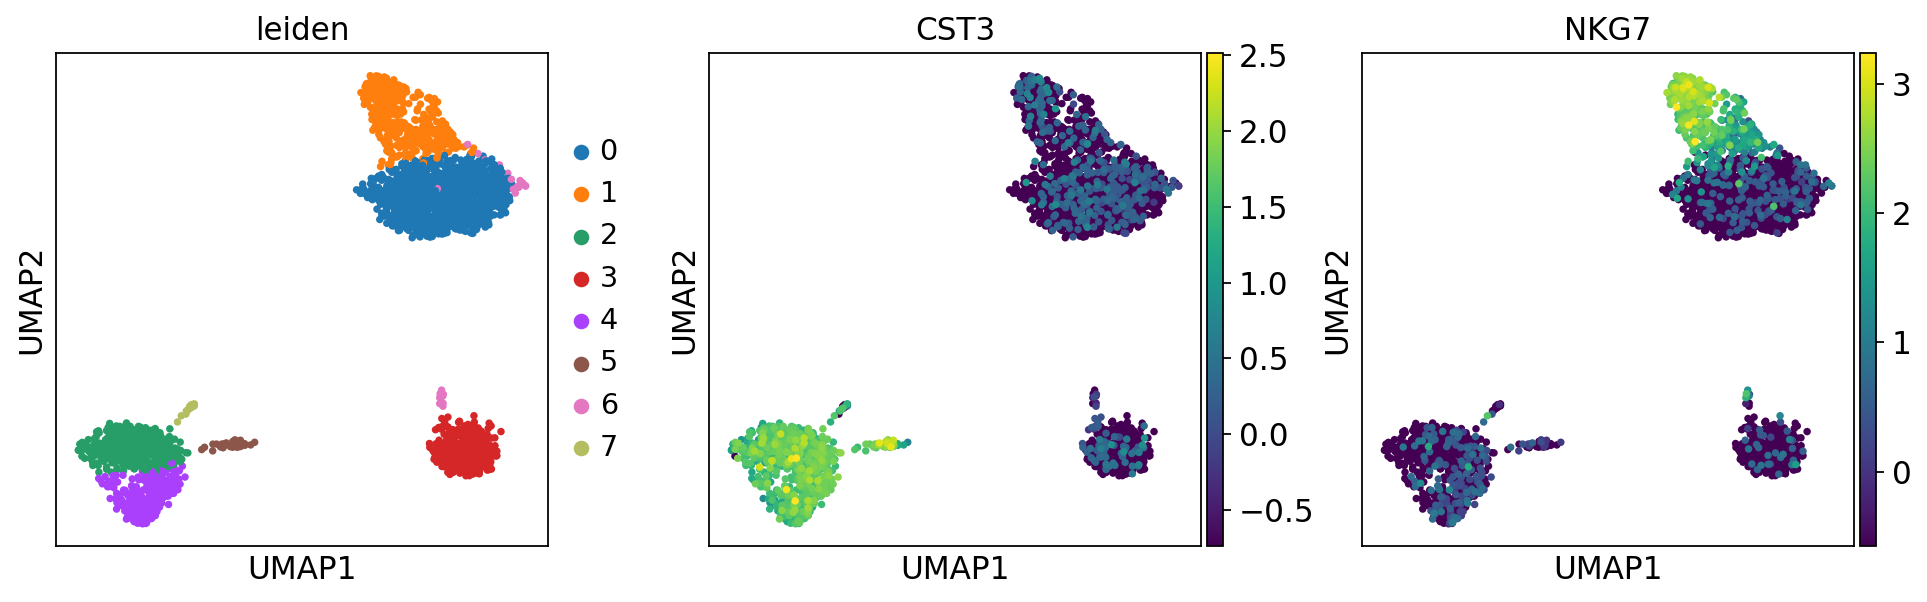

In [23]:
# 缩放数据并运行 PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# 构建邻面图 (Neighbor Graph)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# 运行 UMAP 降维
sc.tl.umap(adata)

# 使用 Leiden 算法聚类
sc.tl.leiden(adata)

# 绘图展示
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [26]:
adata.write(results_file)

| UMAP 维度 | 观察重点 | 识别结论示例 |
| :--- | :--- | :--- |
| **Leiden** | 颜色的边界是否清晰 | 分成了 8 个潜在的细胞亚群 |
| **CST3** | 信号集中在 Cluster 3/4 | Cluster 3 和 4 是 Monocytes |
| **NKG7** | 信号集中在 Cluster 1 | Cluster 1 很大概率是 NK 或 T 细胞 |
| **Overlap** | CST3 与 NKG7 是否有重叠 | 通常不重叠，若重叠则可能是 Doublets（双细胞） |

/tmp/ipykernel_10204/1921479417.py:1: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'], save='_pbmc3k_markers.pdf')


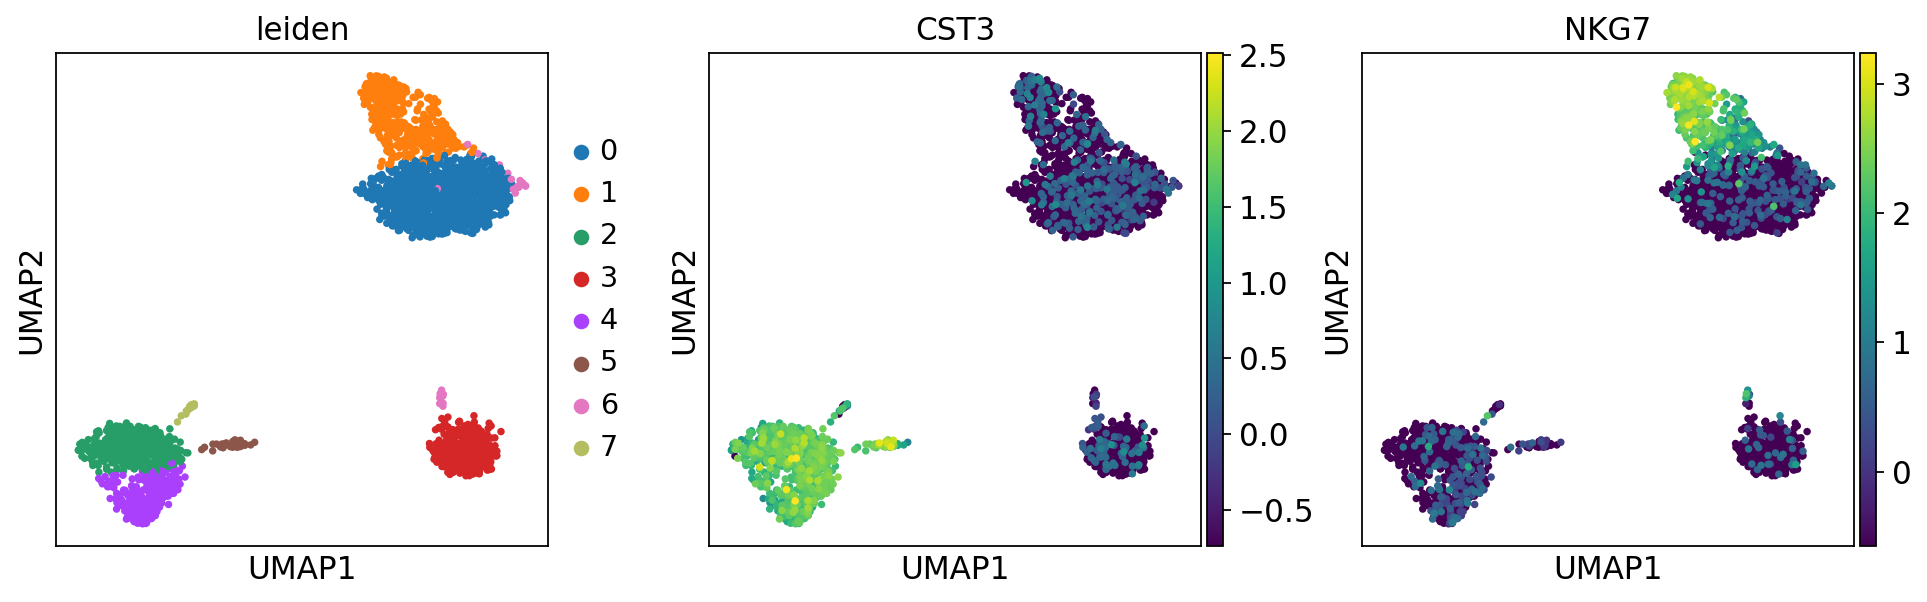

In [27]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'], save='_pbmc3k_markers.pdf')

1. Leiden 分群图 (左侧)
现象：细胞被划分为 8 个簇（Cluster 0-7） 。
解读：每一个颜色代表一组转录组特征相似的细胞。你会发现 Cluster 0 和 1 占据了 UMAP 的主体
2. CST3 表达图 (中间 - 单核细胞 Marker)
现象：在 UMAP某个特定区域出现高亮度信号（表达量达到 2.5-3.0 级别）解读：CST3 是强效的单核细胞（Monocytes）标志物。如果在你的图中 Cluster 2 或 3 的位置变亮，那么它们就是单核细胞。
3. NKG7 表达图 (右侧 - 杀伤性细胞 Marker)
现象：信号分布与 CST3 完全互斥 。
解读：NKG7 在自然杀伤细胞（NK Cells）和细胞毒性 T 细胞中高表达。通常这对应 UMAP 左侧的大簇（如 Cluster 0 或 1）。